**HWRS 582 Base Case Model**

**Input files needed:**
    <br>BASE_top_elev.csv - grid of land surface elevations 

**MODFLOW packages used:**
   <br>DIS - Discretization input
   <br>BAS - Basic
   <br>LPF - Layer-Property Flow
   <br>OC  - Output Control
   <br>PCG - Preconditioned Conjugate Gradient
   <br>RCH - Recharge
   <br>EVT - Evapotranspiration
   <br>WEL - Well
   <br>STR - Stream
    
**Model description:**
<br>Build a steady state model.  The model should have 50x50 cells, each 1000 m in x and in y.  The porosity is 0.10, specific yield is 0.10, and storage coefficient is 0.0001.  There are three layers.  The medium is homogeneous within each layer.  The K of the top and bottom layers is 10 m/day in all three principal directions.  K of the middle layer is the same as the lower layer in the leftmost 20 columns, but it is 0.0001 m/day in the z direction in the remaining columns. The bottom of the domain is topographically flat and the bottom layer is 40 m thick.  The middle layer is 5 m thick and is also flat.  The top layer elevation is provided in an Excel file below.   The top left and bottom left corners of the domain are 'rounded' by bedrock.  Specifically, in the top, there is a triangle of no flow cells (added under BCs) extending from row 45, column 1 to row 50, column 6, inclusive, comprising a total of 21 no flow cells.  There is a symmetric no flow region in the top left corner.  The middle layer has similar regions extending from row 43, column 1 to row 50, column 8.  The bottom layer: row 41, column 1 to row 50, column 10. 

The right boundary in all of the layers has a constant head of 70 m relative to the datum, which is located at the bottom of the domain. All other boundaries are no flow. 

Recharge occurs at a rate of 4E-5 m/day in the leftmost 15 columns and zero elsewhere.  

A stream extends from the left to the right boundary in row 26.  The stream width, length, and thickness are 1.  No flow is entering the stream (from tributaries).  The K of the streambed is 1000 m/day.  The roughness is 0.04 and the slope is 0.001.  The streambed elevation is one m below ground surface and the stage is 0.5 m.  The stream is a 'weak sink' with a strength of 0.5, meaning that half of the particles that enter a stream cell are captured by the stream.  (This is set under MODPATH/Particle Options.)     

ET is zero in the left half of the domain.  ET is 1E-5 m/day in the right half of the domain.  ET occurs at a rate of 5E-4 m/day in a riparian area that extends from the left boundary to the right boundary and occupies rows 23 to 29, inclusive.  The extinction depth is 1 m everywhere.

There is a well that is used for water supply by the local community, which is completed in the bottom layer at row 21 and column 38.  It is pumped at a rate of 1500 m3/day. 

The description above defines the system before a proposed new agricultural is realized.  The field is proposed to cover a 2000 m by 2000 m area; 1/8th of the area will be irrigated agriculture at any time.  The rectangular irrigated fields extend between rows 21 and 22 (inclusive) and columns 19 and 20 (inclusive).  

ET for the crop is zero - it is accounted for in the calculated recharge beneath the field. The recharge rate is assumed to be 20% of the water demand of the crop, representing intentional excess irrigation to avoid soil salinization.  The water uses of wheat, pistachios, and cotton on a daily basis are: 0.004; 0.006; and 0.008 m/day.  This leads to recharge rates of (e.g. 0.004 * 0.125 * 0.2 = 0.0001): 0.0001, 0.00015, and 0.0002 m/day for these crops, respectively.

Water is provided for irrigation from a well that is completed in the top layer at row 12 and column 14.  The pumping rate is equal to the crop water demand plus 20% for excess irrigation plus 30% for irrigation inefficiency.  For wheat, pistachios, and cotton, the pumping rates are (e.g. 0.004 *0.125 * 1.5 * 2000 * 2000 = 3000 m3/day): 3000; 4500; and 6000 m3/day. 

**Variants**
<br><br>
PART I: PRE-DEVELOPMENT MODEL, NO SEASONALITY
<br>Build the base model as described above without the proposed agricultural activity.  Run the model as steady state with no pumping from the town's well.  This is your pre-development model.

PART II: PRE-DEVELOPMENT MODEL, WITH SEASONALITY
Build the base model as described above without the proposed agricultural activity.  Run the model as transient for 25 years with no pumping from the town's well.  Recharge takes place from April through September (inclusive) at the rates given in the problem description.  How long does it take for the model to reach a cyclical steady state (annual variations, but no trends)?  Provide evidence to support your conclusion.  This is the required 'burn in' time of your seasonal pre-development model.

PART III: POST-DEVELOPMENT MODEL, WITH SEASONALITY
<br>Build the base model as described above without the proposed agricultural activity.  Run the model as transient for 100 years PLUS your burn in time.  There is no pumping from the town's well during the burn in period.  The town's pump operates for the next 100 years.  The town's water demand increases exponentially, with the pumping rate changed every 10 years following the equation: Q = 1.5 * t^1.5, for Q in m3/day and t in years.  To avoid confusion, this means that the pumping rates starting in years 0, 10, 20 ... 90 are: 0; 47; 134; 246; 379; 530; 697; 878; 1073; and 1281 m3/day.  This model defines the system before the proposed agricultural activity.

PART IV: POST-DEVELOPMENT MODEL, WITH SEASONALITY - FUTURE PROJECTION
<br>Using the model that you built in Part III, project out 100 years.  (Remember to project the town's water demand, too!)  Compare this model with your pre-development model with seasonality.  How can you quantify the impacts of the town's water extraction on the hydrologic system?  Describe your metrics precisely.

PART V: POST-AG MODEL, WITH SEASONALITY - FUTURE PROJECTION
<br>Add the proposed agricultural element (pumping and localized recharge).  This activity begins in year 100.  Both pumping and recharge occur at the rates described and are continuous throughout the year.  Project out 100 years.  Compare this model with your post-development model with seasonality.  How can you quantify the impacts of the town's proposed agricultural element on the hydrologic system?  How do these impacts compare with the impacts of the town's pumping?  How will the agricultural element affect the town's ability to meet its water demand (both for quantity and quality?)


**Import Python packages**

In [1]:
#Import FloPy:
import flopy

#Import analysis & plotting tools:
import numpy as np
import flopy.utils.binaryfile as bf
import os
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

flopy is installed in C:\Users\Chloe\Anaconda3\envs\scama\lib\site-packages\flopy


**Model setup**
<br> Pre-agriculture

In [2]:
##Name:
modelname = "BASE_preag"

##Grid:
nrow = 50          #number of rows
ncol = 50          #number of columns
delr = 1000.       #width of each cell along rows (so really this is column width along x axis)
delc = 1000.       #width of each cell along columns (so really this is row height along y axis)
Lx = ncol*delr     #width of domain in x (across columns) = number of columns x cell width
Ly = nrow*delc     #width of domain in y (across rows) = number of rows x cell height

##Layers:
nlay = 3                 #number of layers
layers = np.arange(nlay) #array of layers
ztop = np.genfromtxt('BASE_top_elev.csv', delimiter=',')   #top elevation of top layer (import from csv file) (dim: nrow,ncol)
ztop[0,0] = 125.                                           #insert missing initial value (not sure why didn't import)
zbot = 0.                         #bottom elevation of model

botm = np.zeros((nlay,nrow,ncol)) #create array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[1,:,:] = 40.                 #bottom elevation of middle layer (1) is 40 m
botm[0,:,:] = 45.                 #bottom elevation of top layer (0) is 45 m

tops = np.zeros((nlay,nrow,ncol)) #create array of zeros for top elevation for each model cell
tops[0,:,:] = ztop                #top elevation of top layer is ztop
tops[1,:,:] = botm[0,:,:]         #top elevation of middle layer is bottom elev of top layer
tops[2,:,:] = botm[1,:,:]         #top elevation of bottom layer is bottom elev of middle layer


In [3]:
##Medium properties:

#Hydraulic conductivity:
#Kx and Ky:
K_horiz = 10.    #assign horizontal hydraulic conductivity (along rows)
K_ratio = 1.     #assign ratio of Ky/Kx (aka Kcol/Krow) - if Kx=Ky, ratio=1
#Kz (assign zones):
zones = [0,1]                         #list the zone #s
Kz_zones = np.zeros((nlay,nrow,ncol)) #define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz_zones[1,:,20:50] = 1               #assign 1 to the coordinates for zone 1 (middle layer, col 21-50)
#Kz (assign values to zones):
Kz_val = [10.,0.0001]                   #list the K values in each zone (m/day)
Kz = np.zeros((nlay,nrow,ncol))         #define an array of zeros the size of the model grid
for zone in zones:                      #loop over number of zones
    mask = 1 * (Kz_zones == zone)       #create an array of 1s & 0s where each cell in current zone = 1
    Kz = (mask * Kz_val[zone]) + Kz     #assign current K value to current zone & keep values assigned to previous zones

#Porosity, storage, specific yield, confined/unconfined:
n = 0.1          #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1         #assign specific yield
uncnf = 1        #if 0 then confined, if >0 then unconfined

In [4]:
##Outputs:
#this section usually does not change

oc_spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...']
ipakcb = 53    #unit to save cell-by-cell outputs to


In [5]:
##Constant head boundary conditions:
#if ibound < 0, constant head, if = 0, inactive/no-flow, if > 0 active.

#create arrays to indicate active cells (ibound) and starting heads (H_init):
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)    #integer array of dim (z,y,x), makes all cells active                                                     
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float (i.e. decimal) array, sets all initial heads to 1.0

#set head at right boundary:
H_right = 70.               #define constant head value (m)
ibound[:,:,ncol-1] = -1     #replace rightmost column (all zs, all ys, last x) with -1 to indicate constant head
H_init[:,:,:] = H_right     #set initial head value across entire model grid

#set no-flow cells at corners:
corners = [6, 8, 10]           #list corner values of no-flow triangles in each layer
for lay in layers:             #iterate over layers
    corner = corners[lay]             #choose corner value for current layer
    for row in np.arange(corner):     #iterate over rows              
        col = (corner-row)              #calculate max column corresponding to current row
        ibound[lay,row,0:col] = 0       #replace top corner cells with 0s to indicate no flow
        ibound[lay,49-row,0:col] = 0    #replace bottom corner cells with 0s to indicate no flow
        

In [6]:
##Recharge:

#define zones:
zones = [0,1]                        #list recharge zone #s
R_zones = np.zeros((nlay,nrow,ncol)) #define an array of zeros the size of the model grid
R_zones[0,:, 0:15] = 1               #assign 1 to the coordinates for zone 1

#assign values to zones:
R_val = [0,4e-5]                   #list the recharge fluxes in each zone (m/day)
R = np.zeros((nrow,ncol))          #define an array of zeros the size of the model grid
for zone in zones:                 #loop over number of zones
    mask = 1 * (R_zones[0,:,:] == zone) #create an array of 1s & 0s where each cell in current zone = 1
    R = (mask * R_val[zone]) + R        #assign current rech flux to current zone & keep fluxes assigned to previous zones
    

In [7]:
##ET:

#define zones:
zones = [0,1,2]                         #list ET zone #s
ET_zones = np.zeros((nlay,nrow,ncol))   #define an array of zeroes the size of the model grid
ET_zones[0,:, 25:50] = 1             #assign 1 to the coordinates for zone 1
ET_zones[0,22:29, :] = 2             #assign 2 to the coordinates for zone 2

#assign values to zones
ET_val = [0, 1e-5, 5e-5]             #list the values of ET in zones
ET = np.zeros((nrow,ncol))           #define an array of zeros the size of the model grid
for zone in zones:                   #loop over an index of the zones
    mask = 1 * (ET_zones[0,:,:] == zone)    #create an array of 1s & 0s where each cell in current zone = 1
    ET = (mask * ET_val[zone]) + ET  #assign current ET value to current zone and keep ET assigned to previous zones

#set the ET surface:
#this is the elevation with respect to the datum at which the max ET rate occurs
#should default to being the same as the land surface elevation
ET_surf = ztop

#set the extinction depth:
extinction_depth = np.zeros((nrow,ncol))   #define an array of zeros the size of the model grid
extinction_depth[:] = 1.0                  #assign extinction depth of 1 m to all cells

In [8]:
##Wells:
well_loc = [2,20,37]       #well location: [lay, row, col]
Qwell = -1500.             #well pumping rates (m3/day)
well_info = [well_loc[0],well_loc[1],well_loc[2], Qwell]  #well info: [lay, row, col, pumping rate]
well_spd = {0: well_info}    #create a dictionary with entries for each stress period

well_map = np.zeros((nlay,nrow,ncol))    #define an array of zeros the size of the model grid
well_map[well_loc[0],well_loc[1],well_loc[2]] = 1   #assign 1s to well locations - used later for plotting

In [9]:
##Stream (using STR package):
nreach = 48                          #number of reaches (i.e. cells)
nseg = 1                             #number of segments
segments = np.ones((nreach),dtype=np.int32)      #integer array of segment numbers for each reach
mf_rows = 25*np.ones((nreach),dtype=np.int32)    #integer array of row #s for each reach 
mf_cols = np.arange(1,nreach+1)      #integer array of col #s for each reach 
icalc = 0                            #0 = fixed stage, >0 = calculated stage
const = 86400.0                      #multiplication constant for m3/day - see documentation for other units
istcb2 = 53                          #save outflows to cbb file
lay = 0                              #layer for stream
flow = 0.                            #inflow to stream (m3/day)
stage = 0.5                          #stage of stream (height above streambed surface in m)
Kstream = 1000.                      #K of streambed (m/day)
width = 1.                           #x-sectional width of channel (m)
slope = 0.001                        #slope of streambed (m/m)
rough = 0.04                         #roughness of streambed
thickness = 1.                       #thickess of streambed sediment (m)

#Calculate streambed elevations:
surf_elev = np.zeros((nreach))       #create array of zeros the length of the stream
for i in np.arange(nreach):                       #iterate over stream reaches
    surf_elev[i] = ztop[mf_rows[i],mf_cols[i]]    #pull land surface elevation from ztop for each stream cell

Stop = surf_elev - 1            #elevation of the top of the streambed (1 m below land surface) (m)
Sbot = Stop - thickness         #elevation of the bottom of the streambed (m)
stage_elev = Stop + stage       #elevation of the water surface in the stream (m)

#Create map of stream cells for plotting:
str_map = np.zeros((nlay,nrow,ncol)) #array of zeros the size of the model grid
str_map[0,mf_rows+1,mf_cols] = 1       #assign 1s to cells with a stream reach in them

#Create FloPy input dictionaries:
str_info = np.zeros((nreach,13))   #create array of zeros for reaches
for i in np.arange(nreach):        #iterate over reaches
    #create stream info array: [lay, row, col, seg, reach, flow, stage, cond, sbot, stop, width, slope, rough]
    str_info[i,:] = [lay, mf_rows[i], mf_cols[i], segments[i], i, flow, stage_elev[i], Kstream, Sbot[i], Stop[i], width, slope, rough]

str_spd = {0: str_info}                        #create dictionary of stream info keyed to stress periods
seg_info = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   #create segment info array - all zeros since only one segment
str_segd = {0: seg_info}                       #create dict of segment info keyed to stress periods


**Display summary of model inputs**

Model name: BASE_preag
    Model grid: 3 layers x 50 rows x 50 cols;  Cell dimensions: 1000.0m x 1000.0m
    Storage properties: n = 0.1, Sy = 0.1, S = 0.0001


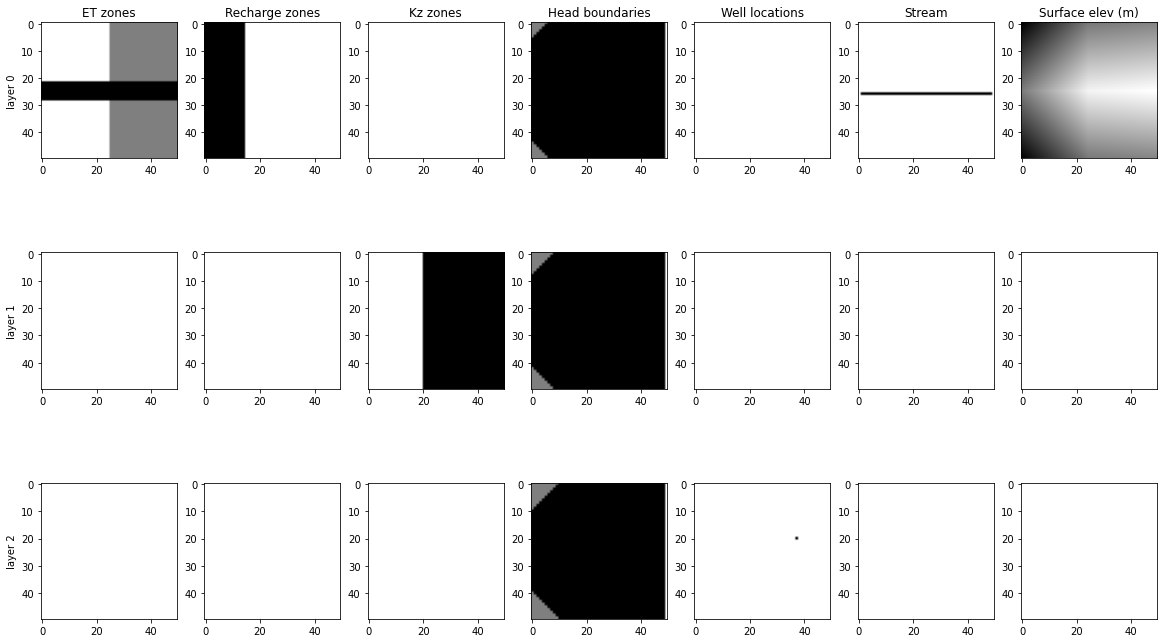

In [10]:
#Print model summary (optional: change run to 'y' to run):

run = 'y'
if run == 'y':
    
    text = '''Model name: {}
    Model grid: {} layers x {} rows x {} cols;  Cell dimensions: {}m x {}m
    Storage properties: n = {}, Sy = {}, S = {}'''                     #text to print
    print(text.format(modelname, nlay,nrow,ncol, delr,delc, n,Sy,Ss))  #values to fill curly brackets above with

    #Plot spatial distribution of model parameters:
    pars = [ET_zones, R_zones, Kz_zones, ibound, well_map, str_map, tops]     #create an array of the parameters we want to plot
    parnames = ['ET zones','Recharge zones','Kz zones','Head boundaries','Well locations', 'Stream', 'Surface elev (m)'] #create list of names for parameters
    f0,ax0 = plt.subplots(nlay,len(pars),figsize=(20,12))  #create figure and axis objects with subplots for each layer & each parameter
                                                           #there will be (nlay) rows & (length of pars) columns of subplots

    for lay in np.arange(nlay):                              #loop over layer indices
        for ipar in np.arange(len(pars)):                    #loop over parameter list indices
            ax0[lay,ipar].imshow(pars[ipar][lay,:,:],cmap=cm.binary)    #plot zones for each parameter and each layer in corresponding subplot
            ax0[lay,0].set_ylabel('layer '+str(lay))                    #label each layer
            ax0[0,ipar].set_title(parnames[ipar])                       #label each parameter
            
    plt.show()

**Create package objects, write MODFLOW input files, run MODFLOW**

In [11]:
#Note: running this section multiple times without changing filenames (see block above) will overwrite the existing 
#files & generate a warning that existing packages are being replaced. This is fine.

#Create model object:
mf = flopy.modflow.Modflow(modelname, exe_name='mf2005')    #MODFLOW executable must be in same folder, named mf2005.exe
    
#Create objects for each package (see GHW1 notebook for details):
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, 
                               delc=delc, top=ztop, botm=botm)         #DIS (Discretization): creates model grid   
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=H_init)         #BAS (Basic): assigns head boundaries
lpf = flopy.modflow.ModflowLpf(mf, laytyp=uncnf, chani=0, hk=K_horiz, hani=K_ratio, vka=Kz, 
        ss=Ss, sy=Sy, storagecoefficient=False, ipakcb=ipakcb)                #LPF (Layer Property Flow): assigns flow props between cells
oc = flopy.modflow.ModflowOc(mf, stress_period_data=oc_spd, compact=True) #OC (Output Control): Decides what outputs to save
pcg = flopy.modflow.ModflowPcg(mf)                                        #PCG (Preconditioned Conjugate Gradient)
rch = flopy.modflow.mfrch.ModflowRch(mf, rech=R)                          #RCH (Recharge)
evt = flopy.modflow.mfevt.ModflowEvt(mf, surf=ztop, evtr=ET, exdp=extinction_depth, ipakcb=53)  #EVT (Evapotranspiration)
wel = flopy.modflow.mfwel.ModflowWel(mf, stress_period_data=well_spd)     #WEL (Well)  
strm = flopy.modflow.mfstr.ModflowStr(mf, mxacts=nreach, nss=nseg, ntrib=0, ndiv=0,icalc=icalc, const=const, ipakcb=ipakcb,  istcb2=istcb2, dtype=None,
        stress_period_data=str_spd, segment_data=str_segd, extension='str')  #STR (Stream)

In [12]:
#Write MODFLOW input files:
mf.write_input()

#Run MODFLOW:
success, buff = mf.run_model()

FloPy is using the following  executable to run the model: C:\USGS_apps\MF2005.1_12\MF2005.1_12\bin\mf2005.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: BASE_preag.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/06/19 15:50:05

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/06/19 15:50:05
 Elapsed run time:  0.137 Seconds

  Normal termination of simulation


**Run MODPATH**

In [13]:

mp = flopy.modpath.Modpath(modelname=modelname+'_mp', exe_name='mp6.exe', 
        modflowmodel=mf, model_ws=None, dis_file=modelname+'.dis', 
        head_file=modelname+'.hds', budget_file=modelname+'.cbc')                 #create MODPATH model object
mpb = flopy.modpath.ModpathBas(mp, hdry=mf.lpf.hdry, laytyp=mf.lpf.laytyp, 
        ibound=ibound, prsity=n)                                                  #create MODPATH BAS object
sim = mp.create_mpsim(trackdir='forward', simtype='pathline', packages='RCH')     #create MODPATH simulation

mp.write_input()                 #write MODPATH input files
mp.run_model(silent=False)       #run MODPATH


FloPy is using the following  executable to run the model: .\mp6.exe
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00                                                                       
Particle tracking complete. Writing endpoint file ...                                                                               
End of MODPATH simulation. Normal termination.


(True, [])

**Post-process results**

In [14]:
##Get outputs:
#This section usually doesn't change much - ignore the FutureWarning

#Get MODFLOW outputs:
hds = bf.HeadFile(modelname+'.hds')    #reads the binary head file
times = hds.get_times()                #returns a list of timesteps
head = hds.get_data(totim=times[-1])        #returns a numpy array of heads for specified time (last timestep)
#Get cell-by-cell outputs from cbb:
#string options are in the list file under output control (make sure to include spaces!)
cbb = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
kstpkper_list = cbb.get_kstpkper()          #returns a list of stress periods & timesteps
frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]      #returns an array of flow rates for right face of cells
fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]      #returns an array of flow rates for front face of cells
stf = cbb.get_data(text='STREAM FLOW OUT ', totim=times[-1])[0]     #returns an array of flow rates in stream
stl = cbb.get_data(text='  STREAM LEAKAGE', totim=times[-1])[0]     #returns an array of leakage rates in stream
etf = cbb.get_data(text='              ET', totim=times[-1])[0]     #returns array of ET flow rates

#Get MODPATH outputs:    
endobj = flopy.utils.EndpointFile(modelname+'_mp.mpend')   #get the MODPATH endpoint file
ept = endobj.get_alldata()                                 #import the endpoint data to FloPy
#convert ept to an array:
ept_array = np.zeros((len(ept),len(ept[0])-1))             #create an empty array the same dimensions as the ept file
for row in np.arange(len(ept)):                            #loop over the ept file rows
    for col in np.arange(len(ept[0])-1):                   #loop over the ept file columns (except the last one)
        ept_array[row,col] = ept[row][col]                 #assign each ept item to the array
        

In [15]:
#Display water budget:

#Get water budget information:
lst = flopy.utils.MfListBudget(modelname+'.list')       #read list file
budget = lst.get_data()                                 #get cumulative water budget for last timestep
labels = [str(budget[i][2])[2:] for i in np.arange(len(budget))] #get and trim labels for each budget item (one-line for loop)
vals = [budget[i][1] for i in np.arange(len(budget))]   #get values for each budget item

#Print water budget:
print('%25s'%'MASS BALANCE','\n')   #print right-justified header taking up 25 spaces, then go to new line
b=[print("%25s"%labels[i],'\t',"%10s"%vals[i]) for i in np.arange(len(budget))]  #iterate to print each item in buget

             MASS BALANCE 

              STORAGE_IN' 	        0.0
        CONSTANT_HEAD_IN' 	        0.0
                WELLS_IN' 	        0.0
                   ET_IN' 	        0.0
             RECHARGE_IN' 	    28320.0
       STREAM_LEAKAGE_IN' 	  2950.5386
                TOTAL_IN' 	   31270.54
             STORAGE_OUT' 	       -0.0
       CONSTANT_HEAD_OUT' 	  -17391.61
               WELLS_OUT' 	    -1500.0
                  ET_OUT' 	 -2750.3516
            RECHARGE_OUT' 	       -0.0
      STREAM_LEAKAGE_OUT' 	  -9628.587
               TOTAL_OUT' 	 -31270.547
                  IN-OUT' 	 -0.0078125
     PERCENT_DISCREPANCY' 	       -0.0


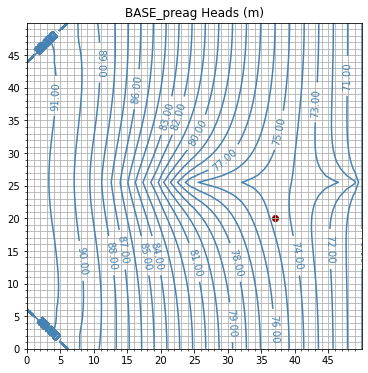

In [16]:
#Plot contour map of heads in Layer 1 at last timestep:

#Create figure & plot data:
f1,ax1 = plt.subplots(1,1,figsize=(6,6)) #create & return figure & axes at position (row, col) of size 6x6 inches
levels = np.arange(1,100,1)  #creates an array of values used to determine which contour values to draw
extent = (0, ncol, 0, nrow)              #sets plot boundaries (x0,x1,y0,y1)
c = plt.contour(head[0,:,:], extent=extent, levels=levels, colors='SteelBlue')  #plots contours for all rows & columns in layer 1
s = plt.scatter(well_info[2], well_info[1], c='DarkRed')    #plots well locations (col = x, row = y)

#Format grid & axes:
major_ticks = np.arange(0,nrow,5)         #creates an array for major tick marks every 5
minor_ticks = np.arange(0,nrow)           #creates an array for minor tick marks every 1

ax1.set_xticks(major_ticks)             #sets major ticks
ax1.set_xticks(minor_ticks, minor=True) #sets minor ticks
ax1.set_yticks(major_ticks)
ax1.set_yticks(minor_ticks, minor=True)

ax1.grid(which='both')                  #turns grid on for both major and minor ticks

#Labels:
plt.clabel(c, fmt='%1.2f')              #adds contour labels as floats with 2 decimal places       
plt.title(modelname+' Heads (m)')       #adds a title

#Display & save figure:
plt.show(f1)                            #displays plot (not usually necessary)
#plt.savefig(modelname+'_head_contours.png')    #optional: saves figure as a .png file 


In [17]:
#Plot cross-section of heads along center row:
run = 'n'
if run == 'y':
    
    #Create figure & plot data:
    f2,ax2 = plt.subplots(1,2,figsize=(15,5))  #create a figure object of width 15 in and height 5 in, with two subplots
    ax2[0].plot(np.arange(ncol), head[0,nrow//2,:]) #plots heads at layer 0, center row, all columns

    #Display layers:
    ax2[0].plot(np.arange(ncol), botm[1,nrow//2,:],'--k',linewidth=1)  #plot bottom elevation of middle layer as a thin dashed black line
    ax2[0].plot(np.arange(ncol), botm[0,nrow//2,:],'--k',linewidth=1)  #plot bottom elevation of top layer
    ax2[0].plot(np.arange(ncol), ztop[nrow//2,:],'--k',linewidth=1)    #plot top elevation of top layer

    #Format grid & axes:
    major_ticks = np.arange(0,nrow,5)         #creates an array for major tick marks every 5
    minor_ticks = np.arange(0,nrow)           #creates an array for minor tick marks every 1
    ax2[0].set_xticks(major_ticks)             #sets major ticks
    ax2[0].set_xticks(minor_ticks, minor=True) #sets minor ticks
    ax2[0].grid(which='both')                  #turns grid on for both major and minor ticks  
    ax2[0].set_ylim(bottom=zbot, top=np.amax(ztop))       #sets z limits to model bottom and highest top elev

    #Plot zoomed in view:
    ax2[1].plot(np.arange(ncol), head[0,nrow//2,:]) #plots heads at layer 0, center row, all columns

    #Add titles & axis labels:
    ax2[0].set_title(modelname+' Heads at row '+str(nrow//2)+' (m)')             #adds a title
    ax2[0].set_xlabel('columns')
    ax2[0].set_ylabel('elevation (m)')

    ax2[1].set_title('zoom')             #adds a title
    ax2[1].set_xlabel('columns')
    ax2[1].set_ylabel('elevation(m)')

    #Display figure:
    plt.show(f2)


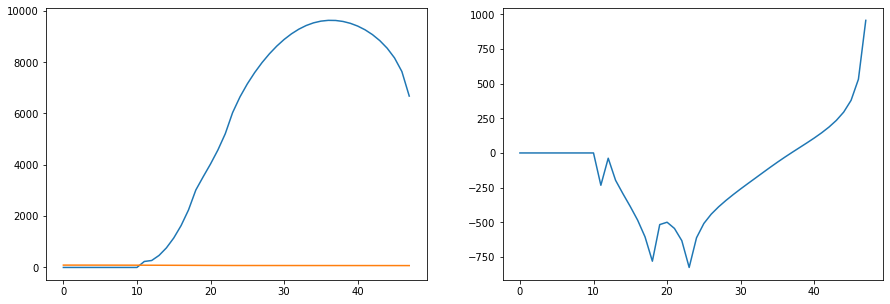

In [20]:
##Plot streamflow & leakage along stream:

run = 'y'
if run == 'y':
    
    #Extract streamflow & leakage data
    strflows = np.zeros((nreach))       #create array of zeros the length of the stream
    strleaks = np.zeros((nreach))       #create array of zeros the length of the stream
    for i in np.arange(nreach):         #iterate over each reach
        strflows[i] = stf[i][1]         #pull flow from stf array
        strleaks[i] = stl[i][1]         #pull leakage from stl array

    #Create figure & plot data:
    f3,ax3 = plt.subplots(1,2,figsize=(15,5))  #create a figure object of width 15 in and height 5 in, with two subplots
    ax3[0].plot(np.arange(ncol-2), strflows) #plot flows 
    ax3[0].plot(np.arange(ncol-2), head[0,nrow//2,1:ncol-1])  #plot heads
    ax3[1].plot(np.arange(ncol-2), strleaks) #plot leakage

    plt.show(f3)                            #displays plot (not usually necessary)

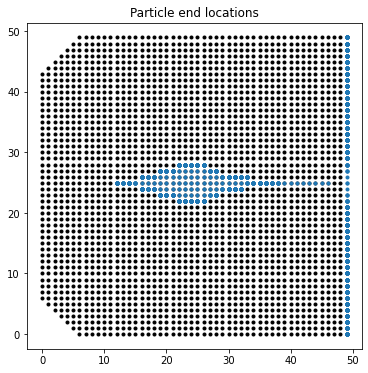

In [21]:
#Plot endpoints of particles:
#see https://pubs.usgs.gov/tm/6a41/pdf/TM_6A_41.pdf (p.33) 
#for information on what the columns of the endpoint file correspond to

run = 'y'
if run == 'y':

    f4,ax4 = plt.subplots(1,1,figsize=(6,6))                       #create & return figure & axes at position (row, col) of size 6x6 inches
    plt.scatter(ept_array[:,8],ept_array[:,7],marker='.',c='k')    #plot start locations in black
    plt.scatter(ept_array[:,20],ept_array[:,19],marker='.')        #plot end locations
    plt.title('Particle end locations')                            #add title


**Export data**

In [ ]:
#Export head array to a CSV file:

import csv                                              #import csv module (this DOESN'T import an actual csv file)
with open(modelname+'FP_heads.csv', 'w', newline='') as csvfile:  #creates an empty csv file called FP_heads
    writer = csv.writer(csvfile, delimiter=',')        
    for i in range(len(head[0,:,0])):                    #writes each row
        writer.writerow(head[0,i,:])
        